<a href="https://colab.research.google.com/github/HWAN722/self-improvement/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Self-Attention
Self-Attention is a mechanism that computes the relevance of each element in a sequence with respect to all other elements **in the same sequence**. It is widely used in natural language processing (NLP) to capture dependencies within a sequence.
* **Input**: A single sequence (e.g., a sequence of word embeddings from a sentence).
* **Purpose**: It calculates relationships between elements within the same input sequence to better understand the context.

**Formula**:

For an input sequence $X = [x_1, x_2, ..., x_n]$, Self-Attention is computed as:


$$ \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right)V $$


where *Q* , *K*, and *V* are the Query, Key, and Value matrices derived from the input *X*.

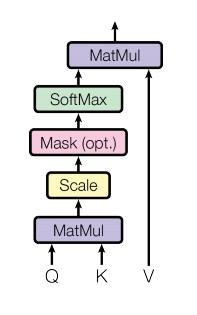


In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by heads"

        self.values = nn.Linear(self.head_dim, embed_size, bias=False)
        self.keys = nn.Linear(self.head_dim, embed_size, bias=False)
        self.queries = nn.Linear(self.head_dim, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        energy = torch.matmul(queries.transpose(1, 2), keys.transpose(1, 2).transpose(2, 3))  # (n, h, q, k)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)

        out = torch.matmul(attention, values.transpose(1, 2))  # (n, h, q, d)
        out = out.transpose(1, 2).contiguous().view(N, query_len, self.heads * self.head_dim)  # Reshape

        out = self.fc_out(out)
        return out


#2. Cross-Attention
Cross-Attention computes the attention between two different sequences: one sequence is used as the query, while the other sequence is used as the key and value. This is commonly used in transformer decoders, where information from the encoder is used to compute the attention.
* **Input**: Two sequences (e.g., query from a decoder and key and value from an encoder).
* **Purpose**: It allows information transfer between different sequences, commonly seen in encoder-decoder architectures.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size must be divisible by heads"

        # Layers for queries, keys, and values
        self.query_layer = nn.Linear(embed_size, embed_size)
        self.key_layer = nn.Linear(embed_size, embed_size)
        self.value_layer = nn.Linear(embed_size, embed_size)

        # Final output linear layer
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value, mask=None):
        N = query.shape[0]  # Batch size
        query_len, key_len, value_len = query.shape[1], key.shape[1], value.shape[1]

        # Linear projections to obtain Q, K, V
        Q = self.query_layer(query)  # Shape: (N, query_len, embed_size)
        K = self.key_layer(key)      # Shape: (N, key_len, embed_size)
        V = self.value_layer(value)  # Shape: (N, value_len, embed_size)

        # Reshape for multi-head attention
        Q = Q.reshape(N, query_len, self.heads, self.head_dim).transpose(1, 2)  # (N, heads, query_len, head_dim)
        K = K.reshape(N, key_len, self.heads, self.head_dim).transpose(1, 2)    # (N, heads, key_len, head_dim)
        V = V.reshape(N, value_len, self.heads, self.head_dim).transpose(1, 2)  # (N, heads, value_len, head_dim)

        # Calculate the attention scores: Q * K^T / sqrt(d_k)
        energy = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (N, heads, query_len, key_len)

        # Apply mask (if provided)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Softmax to get the attention weights
        attention = F.softmax(energy, dim=-1)  # (N, heads, query_len, key_len)

        # Multiply attention weights with V
        out = torch.matmul(attention, V)  # (N, heads, query_len, head_dim)

        # Reshape the output and pass it through the final linear layer
        out = out.transpose(1, 2).contiguous().view(N, query_len, self.embed_size)  # (N, query_len, embed_size)
        out = self.fc_out(out)  # (N, query_len, embed_size)

        return out


#3. Multi-Head Attention
Multi-Head Attention consists of multiple independent attention mechanisms (heads) run in parallel. The outputs of these attention heads are then concatenated and passed through a linear layer. This allows the model to capture information from different subspaces simultaneously, enhancing the model's representational power.
* **Input**: Can be input sequences for self-attention or cross-attention.
* **Purpose**: Enhances the representational capacity of the model by using multiple attention heads in parallel.

**Formula**:
$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, ..., \text{head}_h)W^O $$
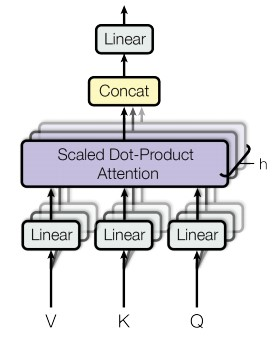

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.heads = heads
        self.self_attention = SelfAttention(embed_size, heads)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        # Perform multi-head self-attention
        attention = self.self_attention(values, keys, query, mask)
        return self.fc_out(attention)


# Key Differences:
**Self-Attention:** Calculates attention within the same sequence, focusing on intra-sequence dependencies.

**Cross-Attention:** Calculates attention between two different sequences, allowing for inter-sequence information transfer.

**Multi-Head Attention:** Executes multiple attention heads in parallel, improving the model's capacity to capture diverse information.

#Summary
**Self-Attention** focuses on dependencies within a sequence.

**Cross-Attention** focuses on interactions between two sequences.

**Multi-Head Attention** applies multiple attention mechanisms to improve the model's expressive power.